In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
from pathlib import Path

import numpy as np

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import precision_recall_fscore_support, PrecisionRecallDisplay

import muon as mu

/Users/chigurh/miniconda3/envs/cellij/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<IPython.core.display.Javascript object>

In [3]:
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Using matplotlib backend: <object object at 0x15c415830>


<IPython.core.display.Javascript object>

In [4]:
# plotting functions
def _lines(ax, positions, ymin, ymax, horizontal=False, **kwargs):
    if horizontal:
        ax.hlines(positions, ymin, ymax, **kwargs)
    else:
        ax.vlines(positions, ymin, ymax, **kwargs)
    return ax


def lined_heatmap(data, figsize=None, hlines=None, vlines=None, **kwargs):
    """Plot heatmap with horizontal or vertical lines."""
    if figsize is None:
        figsize = (20, 2)
    fig, g = plt.subplots(figsize=figsize)
    g = sns.heatmap(data, ax=g, **kwargs)
    if hlines is not None:
        _lines(
            g,
            hlines,
            *sorted(g.get_xlim()),
            horizontal=True,
            lw=1.0,
            linestyles="dashed",
        )
    if vlines is not None:
        _lines(
            g,
            vlines,
            *sorted(g.get_ylim()),
            horizontal=False,
            lw=1.0,
            linestyles="dashed",
        )
    return g

<IPython.core.display.Javascript object>

In [5]:
import cellij

<IPython.core.display.Javascript object>

In [6]:
data_dir = Path("..") / "experiments" / "sparsity_benchmark" / "synthetic"
mdata = mu.read_h5mu(data_dir / "data.h5mu")
mdata

/Users/chigurh/miniconda3/envs/cellij/lib/python3.9/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/Users/chigurh/miniconda3/envs/cellij/lib/python3.9/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


MuData object with n_obs × n_vars = 200 × 1200
  obsm:	'z'
  3 modalities
    feature_group_0:	200 x 400
      varm:	'w', 'w_mask'
    feature_group_1:	200 x 400
      varm:	'w', 'w_mask'
    feature_group_2:	200 x 400
      varm:	'w', 'w_mask'

<IPython.core.display.Javascript object>

In [7]:
# basic parameters
n_samples = mdata.n_obs
n_features = []
for fgn in mdata.mod.keys():
    n_features.append(mdata[fgn].n_vars)
n_views = len(n_features)
n_factors = mdata.obsm["z"].shape[1]

<IPython.core.display.Javascript object>

In [8]:
z = mdata.obsm['z']
w = np.concatenate([mdata[fgn].varm['w'] for fgn in mdata.mod.keys()]).T
w_mask = np.concatenate([mdata[fgn].varm['w_mask'] for fgn in mdata.mod.keys()]).T
y = np.concatenate([mdata[fgn].X for fgn in mdata.mod.keys()], axis=1)
print(z.shape, w.shape, y.shape)

(200, 10) (10, 1200) (200, 1200)


<IPython.core.display.Javascript object>

In [9]:
model_dir = Path("..") / "experiments" / "sparsity_benchmark" / "training_output_Horseshoe"
z_hat = np.load(model_dir / "z.npy")
w_hat = np.load(model_dir / "w.npy")
y_hat = z_hat @ w_hat
print(z_hat.shape, w_hat.shape, y_hat.shape)

(200, 10) (10, 1200) (200, 1200)


<IPython.core.display.Javascript object>

In [10]:
feature_offsets = [0] + np.cumsum(n_features).tolist()
vlines = feature_offsets[1:-1]

<IPython.core.display.Javascript object>

<AxesSubplot:>

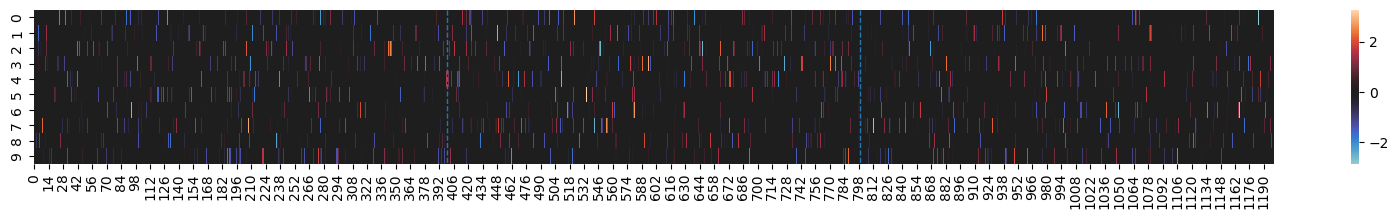

<IPython.core.display.Javascript object>

In [11]:
# factor loadings should be fairly sparse
lined_heatmap(w, vlines=vlines, center=0)

<AxesSubplot:>

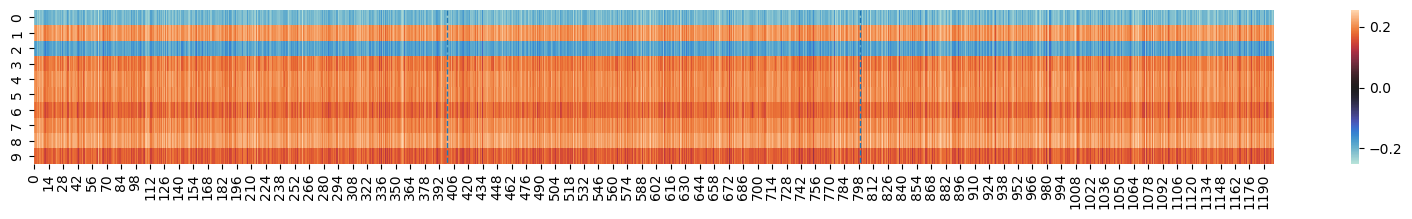

<IPython.core.display.Javascript object>

In [12]:
lined_heatmap(w_hat, vlines=vlines, center=0)

In [13]:
def get_opt_thresh(X, Y, thresh_min=0, thresh_max=1, n_thresh=101):
    thresh_max = min(thresh_max, Y.max())
    print(thresh_max)
    thresholds = np.linspace(thresh_min, thresh_max, n_thresh)
    f1s = []
    for threshold in thresholds:
        prec, rec, f1, _ = precision_recall_fscore_support(
            X.flatten(), (Y > threshold).flatten(), average="binary"
        )
        f1s.append(f1)

    return thresholds[np.argmax(f1s)]

<IPython.core.display.Javascript object>

In [14]:
opt_order = cellij.evaluation.compute_factor_correlation(w, w_hat)[-1]
opt_order

array([2, 8, 3, 4, 6, 9, 5, 1, 7, 0])

<IPython.core.display.Javascript object>

In [15]:
w_hat = w_hat[opt_order, :]
z_hat = z_hat[:, opt_order]

<IPython.core.display.Javascript object>

In [16]:
threshold = get_opt_thresh(
    w_mask,
    w_hat
)
threshold

0.25574833


/Users/chigurh/miniconda3/envs/cellij/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.18158131539821623

<IPython.core.display.Javascript object>

In [17]:
precision_recall_fscore_support((w_mask).flatten(), (w_hat > threshold).flatten(), average="binary")

(0.0944055944055944, 0.6125226860254084, 0.1635967038293747, None)

<IPython.core.display.Javascript object>

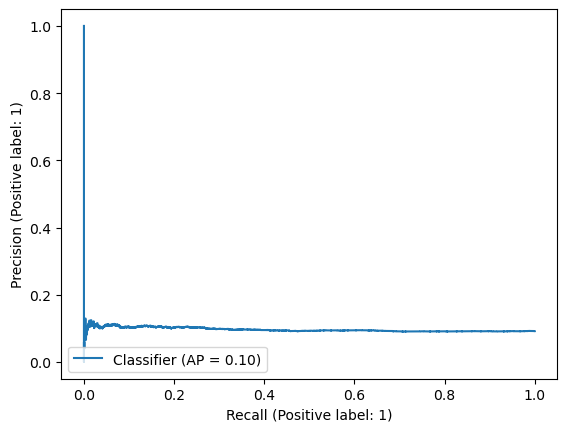

<IPython.core.display.Javascript object>

In [18]:
PrecisionRecallDisplay.from_predictions(w_mask.flatten(), w_hat.flatten())

In [19]:
rmse = mean_squared_error(y, y_hat, squared=False)
r2 = r2_score(y, y_hat)
print(rmse, r2)

0.5099082 -0.04554260194279756


<IPython.core.display.Javascript object>